<a href="https://colab.research.google.com/github/Archalharin/208469/blob/main/SARIMAX_NEW_y_%3C_y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [ ]:
!pip install pyreadstat

In [ ]:
!pip3 install numpy==1.26.4
!pip3 install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
# Dataframe & Linear Algebra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action = "ignore")

# Data preprocessing
from sklearn.preprocessing import PowerTransformer

# Time serie
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Model Evaluation
from math import sqrt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Import dataset

In [ ]:
#อ่านไฟล์
data = pd.read_csv(r"/content/เขื่อนแม่กวงอุดมธารา1.csv")
# data.dropna(inplace = True)
data.set_index('ปี-เดือน', inplace=True)
data.columns = data.columns.str.strip()
data.index = pd.date_range(start = "2013-05", periods = len(data), freq = "M").to_period()
# data.index = data.index.to_timestamp()
data.head()

,y,x1,x2,x3,x4
2013-05,47.34,29.29,65.29,1006.95,2.90
2013-06,45.02,28.86,71.14,1005.26,1.32
2013-07,45.88,27.89,77.24,1005.13,8.80
2013-08,51.90,27.30,80.79,1006.09,9.66
2013-09,77.58,27.46,78.93,1007.70,9.19


Data description

In [ ]:
for i in data.columns:
    data[i] = data[i].astype("float")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 144 entries, 2013-05 to 2025-04
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       144 non-null    float64
 1   x1      144 non-null    float64
 2   x2      144 non-null    float64
 3   x3      144 non-null    float64
 4   x4      144 non-null    float64
dtypes: float64(5)
memory usage: 6.8 KB


# Data visualization

In [ ]:
round(data.describe(), 4)

,y,x1,x2,x3,x4
count,144.0000,144.0000,144.0000,144.0000,144.0000
mean,96.8513,27.1929,69.1835,1009.6231,3.2295
std,55.4457,2.3872,9.1906,3.4939,3.3447
min,23.9200,21.0500,44.6200,1004.3700,0.0000
25%,51.2825,25.7950,63.2000,1006.5275,0.4200
50%,84.6300,27.6550,71.4150,1009.0500,2.3750
75%,123.4925,28.7725,76.0875,1012.8700,4.7775
max,255.8800,32.5400,82.1700,1016.5100,15.1000


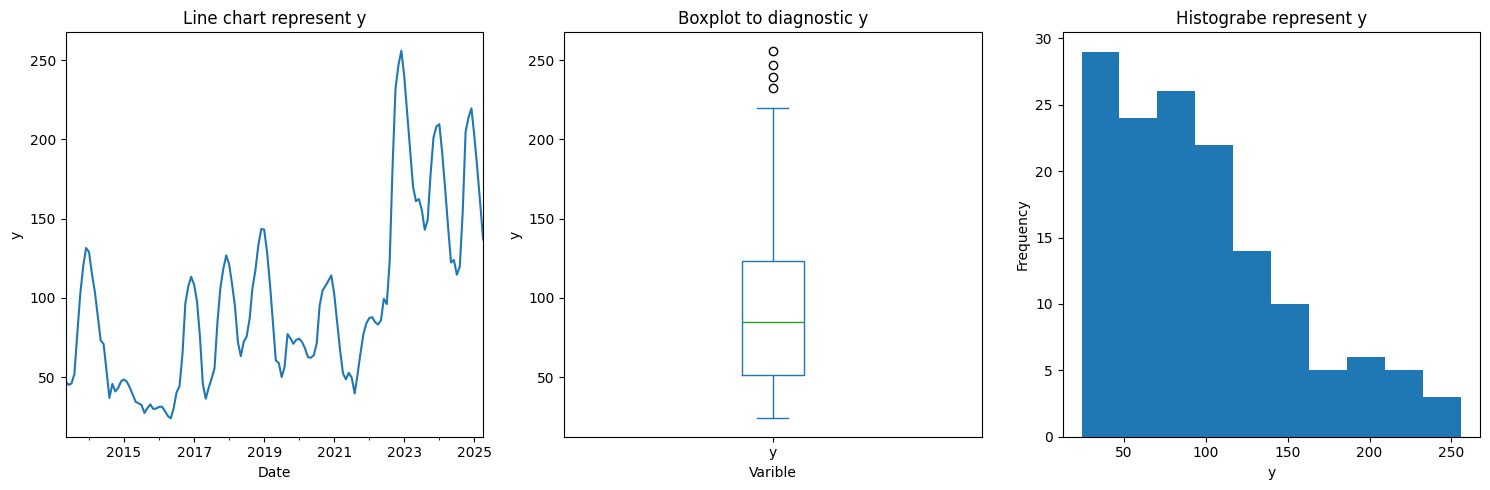

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), facecolor = "w")
kind_list = ["line", "box", "hist"]
for i, kind in enumerate(kind_list):
    data["y"].plot(kind = kind, ax = ax[i])
ax[0].set(xlabel = "Date", ylabel = "y", title = "Line chart represent y")
ax[1].set(xlabel = "Varible", ylabel = "y", title = "Boxplot to diagnostic y")
ax[2].set(xlabel = "y", title = "Histograbe represent y")
plt.tight_layout()
plt.show()

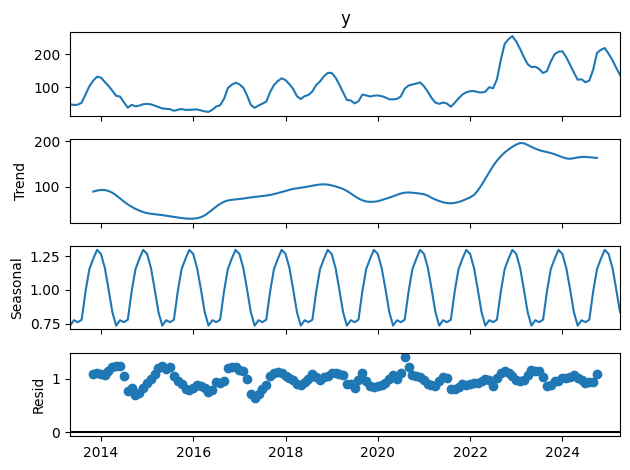

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decompose
sd = seasonal_decompose(data["y"].to_timestamp(), model = "multiplicative", period = 12)

# Plot
sd.plot()
plt.tight_layout()
plt.show()

Correlation matrix

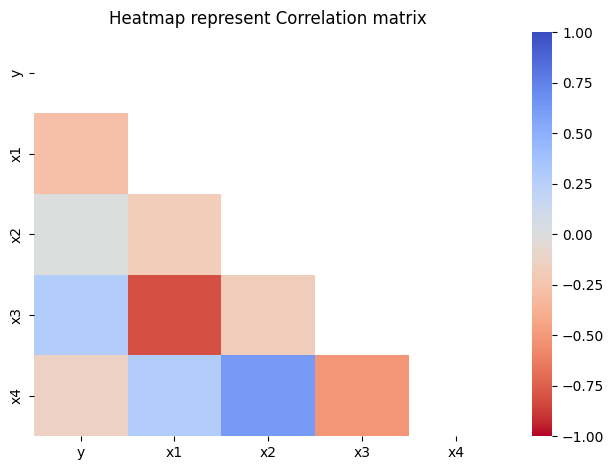

In [ ]:
correlation = data.corr()
sns.heatmap(correlation, vmin = -1, vmax = 1, cmap = "coolwarm_r", mask = np.triu(correlation))
plt.title("Heatmap represent Correlation matrix")
plt.tight_layout()
plt.show()

# Split data

In [ ]:
size = 12
y_train = data["y"][:-size]
x_train = y_train.shift(1)
y_test = data["y"][-size:]
x_test = y_test.shift(1)


x_test

,y
2024-05,NaN
2024-06,122.28
2024-07,123.80
2024-08,114.57
2024-09,119.58
2024-10,153.57
2024-11,204.64
2024-12,213.81
2025-01,219.47
2025-02,202.04


# REGRESSION MODEL SARIMAX

In [ ]:
from statsmodels.api import OLS, add_constant # OLS: Least square method

# Initialize with the index of y_train to ensure proper alignment.
exog_ols_df = pd.DataFrame(index=y_train.index)
exog_ols_df['y'] = y_train.shift(1)

# Drop rows with NaN values. This will remove the first row where y_lag1 is NaN.
exog_ols_df_cleaned = exog_ols_df.dropna()

# Align y_train (endogenous variable) with the cleaned exogenous DataFrame by using its index
y_train_cleaned = y_train[exog_ols_df_cleaned.index]

# Add a constant to the cleaned exogenous DataFrame for the OLS model
x_cleaned_const = add_constant(exog_ols_df_cleaned)

# Fit the OLS model using the cleaned data and the constant term
full_regr = OLS(y_train_cleaned, x_cleaned_const).fit()
print(full_regr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1608.
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           1.05e-74
Time:                        15:13:15   Log-Likelihood:                -534.85
No. Observations:                 131   AIC:                             1074.
Df Residuals:                     129   BIC:                             1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0448      2.514      1.609      0.1



```
```

Check multicolinearity

Stepwise regression

In [ ]:
y = y_train
x = x_train

# SARIMAX Model

Find parameter p, d, q

In [ ]:
#find lembda
power_y = PowerTransformer(method = "box-cox", standardize = False).fit(y_train.values.reshape(-1, 1))
print("Lambda: ", round(power_y.lambdas_[0], 4))
y_tf = power_y.transform(y_train.values.reshape(-1, 1))
y_t_tf = power_y.transform(y_test.values.reshape(-1, 1))


Lambda:  -0.0175


In [ ]:
train_df = pd.DataFrame(y_train)
train_df["y_transform"] = y_tf

train_dff = pd.DataFrame(y_test)
train_dff["y_transform"] = y_t_tf

y_train_tf = np.log(y_train)
y_test_tf = np.log(y_test)
y_train_tf

,y
2013-05,3.857356
2013-06,3.807107
2013-07,3.826029
2013-08,3.949319
2013-09,4.351310
...,...
2023-12,5.338019
2024-01,5.344819
2024-02,5.253163
2024-03,5.128122


In [ ]:
# Definition ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

In [ ]:
df_adf = pd.DataFrame()
df_adf.index = adf_test(train_df["y"]).keys()
df_adf['ADF seasonal differencing order 0'] = adf_test(train_df["y"]).values
df_adf['ADF seasonal differencing order 1'] = adf_test(train_df["y"].diff(periods = 7).dropna()).values
df_adf['ADF seasonal differencing order 2'] = adf_test(train_df["y"].diff(periods = 7).diff(periods = 7).dropna()).values
df_adf['ADF seasonal differencing order 3'] = adf_test(train_df["y"].diff(periods = 7).diff(periods = 7).diff(periods = 7).dropna()).values
round(df_adf.drop(labels = ['#Lags Used', 'Number of Observations Used']), 4)

,ADF seasonal differencing order 0,ADF seasonal differencing order 1,ADF seasonal differencing order 2,ADF seasonal differencing order 3
Test Statistic,-2.1362,-3.0331,-3.3728,-3.2644
p-value,0.2302,0.0319,0.0119,0.0165
Critical Value (1%),-3.4865,-3.4907,-3.4949,-3.4996
Critical Value (5%),-2.8862,-2.8880,-2.8898,-2.8918
Critical Value (10%),-2.5799,-2.5809,-2.5818,-2.5829


In [ ]:
import itertools
max_p  = [0, 1, 2];  max_d = [0];  max_q = [0, 1]
max_SP = [0, 1]; max_SD = [1]; max_SQ = [0, 1]
periods = [12]
order_combinations = list(itertools.product(max_p, max_d, max_q, max_SP, max_SD, max_SQ, periods))
len(order_combinations)

24

In [ ]:
list_sarimax_model = list()
for order in order_combinations:
    start_idx = order[1] + (order[4] * 12)
    model = SARIMAX(endog = y_tf, order = order[:3], seasonal_order = order[3:]).fit()
    fitted = model.fittedvalues
    forecast = model.forecast(steps = len(y_t_tf), exog = y_t_tf)
    mape_train = MAPE(y_tf[start_idx:], fitted[start_idx:]) * 100; mse_train = MSE(y_tf[start_idx:], fitted[start_idx:]); mae_train = MAE(y_tf[start_idx:], fitted[start_idx:])
    mape_test = MAPE(y_t_tf, forecast) * 100; mse_test = MSE(y_t_tf, forecast); mae_test = MAE(y_t_tf, forecast)
    list_sarimax_model.append({"order": order[:3], "seasonal order": order[3:],
                             "MAPE train": mape_train, "RMSE train": sqrt(mse_train), "MAE train": mae_train,
                             "MAPE test": mape_test, "RMSE test": sqrt(mse_test), "MAE test": mae_test})
output_sarimax = round(pd.DataFrame(list_sarimax_model), 4)
output_sarimax = output_sarimax.sort_values(by = "MAPE test", ascending = True).reset_index(drop = True)
output_sarimax

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,seasonal order,MAPE train,RMSE train,MAE train,MAPE test,RMSE test,MAE test
0,"(1, 0, 0)","(1, 1, 1, 12)",2.3205,0.1298,0.0925,1.0846,0.0605,0.0517
1,"(1, 0, 0)","(0, 1, 1, 12)",2.3270,0.1299,0.0928,1.1025,0.0627,0.0525
2,"(1, 0, 1)","(0, 1, 1, 12)",2.0077,0.1146,0.0803,1.4196,0.0729,0.0686
3,"(1, 0, 1)","(1, 1, 1, 12)",2.0045,0.1144,0.0802,1.4751,0.0761,0.0715
4,"(2, 0, 1)","(1, 1, 0, 12)",2.1849,0.1197,0.0876,1.6138,0.0845,0.0766
5,"(0, 0, 1)","(1, 1, 0, 12)",5.6417,0.2854,0.2306,1.7753,0.1006,0.0838
6,"(2, 0, 0)","(0, 1, 0, 12)",2.3143,0.1332,0.0927,1.7802,0.1050,0.0862
7,"(0, 0, 0)","(1, 1, 0, 12)",10.6661,0.5268,0.4371,1.8441,0.1051,0.0870
8,"(2, 0, 1)","(0, 1, 0, 12)",2.3686,0.1311,0.0951,1.9737,0.1040,0.0950
9,"(1, 0, 1)","(0, 1, 0, 12)",2.4082,0.1389,0.0966,1.9972,0.1170,0.0974


SARIMAX 1,0,1,0,1,1,12

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  88.848
Date:                            Wed, 07 Jan 2026   AIC                           -169.696
Time:                                    16:11:16   BIC                           -158.546
Sample:                                05-31-2013   HQIC                          -165.168
                                     - 04-30-2024   Scale                            0.010
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9741      0.039     24.665      0.000       0.897       1.052
ma.L1          0.5029      0.081   

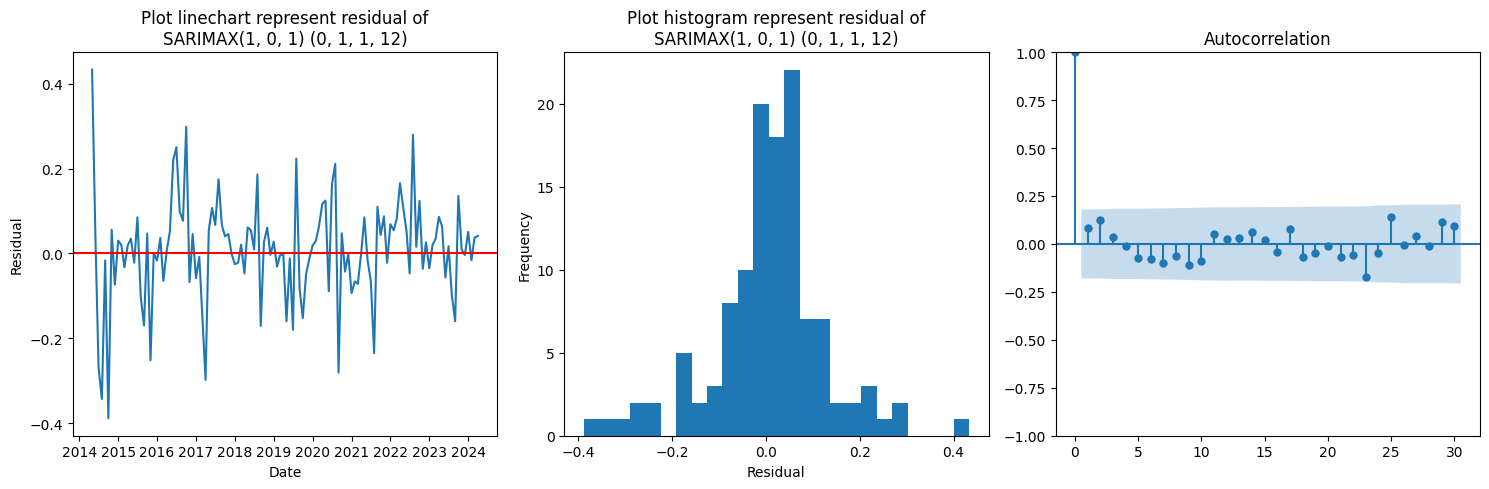

In [ ]:
sarimax_model = SARIMAX(endog = y_train_tf, order = output_sarimax.loc[2, 'order'], seasonal_order = output_sarimax.loc[2, 'seasonal order'], concentrate_scale = True).fit()
print(sarimax_model.summary())

# diagnostic
resid_sarimax = sarimax_model.resid[12:]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), facecolor = "w")
ax[0].plot(resid_sarimax.to_timestamp()) # Convert PeriodIndex to DatetimeIndex for plotting
ax[0].axhline(y = 0, color = "r")
ax[0].set(xlabel = "Date", ylabel = "Residual", title = "Plot linechart represent residual of\nSARIMAX(1, 0, 1) (0, 1, 1, 12)")
ax[1].hist(resid_sarimax, bins = 25)
ax[1].set(xlabel = "Residual", ylabel = "Frequency",title = "Plot histogram represent residual of\nSARIMAX(1, 0, 1) (0, 1, 1, 12)")
plot_acf(resid_sarimax, lags = int(len(resid_sarimax) / 4), ax = ax[2])
plt.tight_layout()
plt.show()

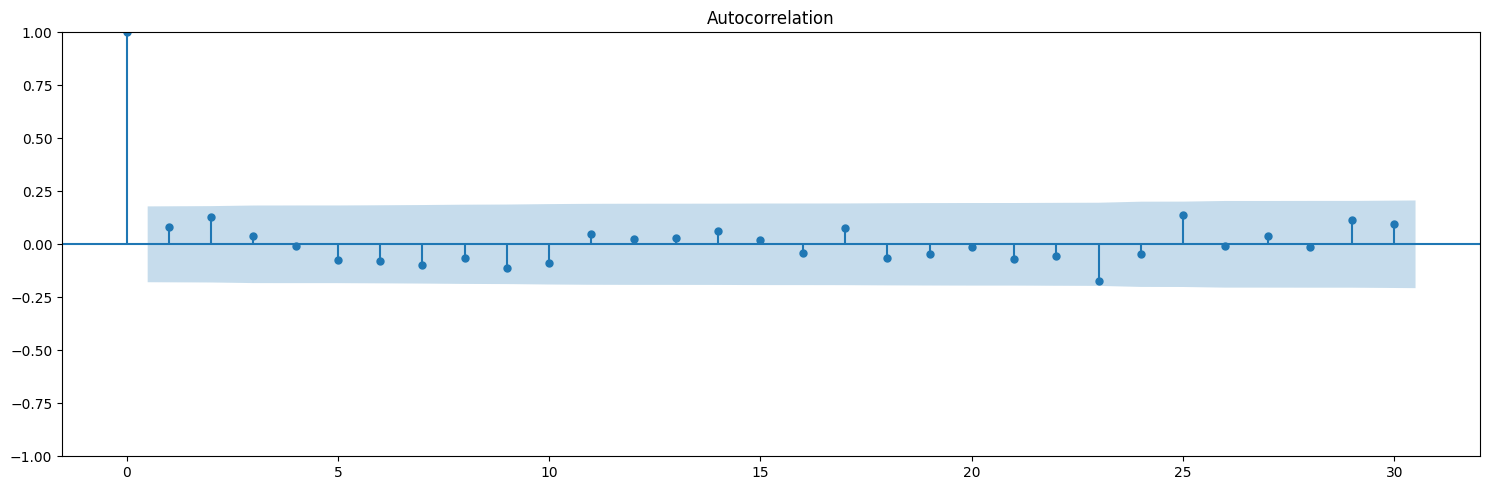

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5), facecolor = "w")
plot_acf(sarimax_model.resid[12:], lags = int(len(sarimax_model.resid[12:]) / 4), ax = ax)
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lag_idx = round(len(sarimax_model.resid[12:])/4, 0)
bj = acorr_ljungbox(sarimax_model.resid[12:], lags = lag_idx, return_df = True)
bj.tail().T

,26,27,28,29,30
lb_stat,21.302114,21.545029,21.567057,23.725521,25.224153
lb_pvalue,0.726206,0.760122,0.800929,0.742346,0.714067


In [ ]:
search_sarimax = auto_arima(y_train_tf,m = 12, information_criterion = "aic", stepwise = True, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-186.514, Time=6.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-98.791, Time=0.28 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-173.230, Time=1.41 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-161.144, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-100.435, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-167.408, Time=0.91 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-174.870, Time=1.51 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-182.682, Time=4.22 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-183.258, Time=2.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-153.223, Time=0.48 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-172.223, Time=2.15 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-178.916, Time=2.45 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-176.524, Time=4.48 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-185.303, Time=1.19 sec
 ARIMA(2,1,1)(1,0,1)

In [ ]:
print(search_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 102.150
Date:                            Wed, 07 Jan 2026   AIC                           -192.301
Time:                                    16:15:48   BIC                           -175.050
Sample:                                05-31-2013   HQIC                          -185.291
                                     - 04-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3145      0.173     -1.817      0.069      -0.654       0.025
ar.L2          0.3862      0.133   

Diagnostics model

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 102.157
Date:                            Wed, 07 Jan 2026   AIC                           -192.314
Time:                                    16:15:51   BIC                           -175.063
Sample:                                05-31-2013   HQIC                          -185.304
                                     - 04-30-2024   Scale                            0.011
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3020      0.195     -1.551      0.121      -0.683       0.080
ar.L2          0.3764      0.142   

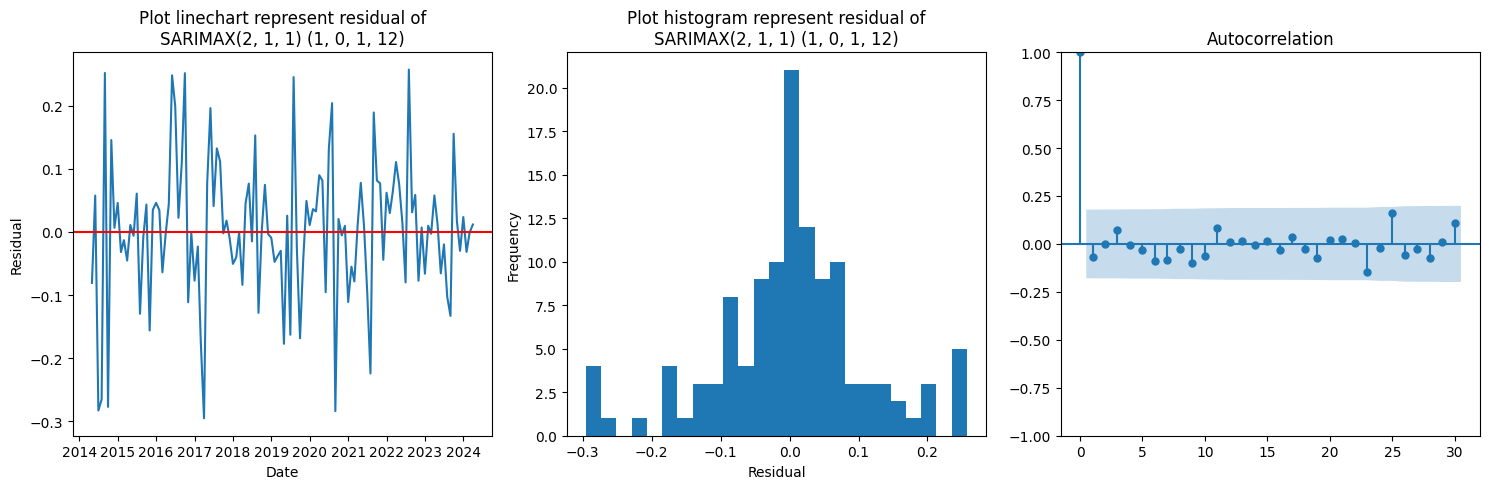

In [ ]:
sarimax_grid = SARIMAX(endog = y_train_tf, order = (2, 1, 1), seasonal_order = (1, 0, 1, 12), concentrate_scale = True).fit()
print(sarimax_grid.summary())

#Error
#print()
#print("MAPE Train: ", MAPE(y_train[12:], sarimax_grid.fittedvalues[12:]) * 100)
#print("MAPE Test: ", MAPE(y_test, sarimax_grid.forecast(steps = len(y_test))) * 100)

# diagnostic
resid_sarimax = sarimax_grid.resid[12:]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), facecolor = "w")
ax[0].plot(resid_sarimax.to_timestamp())
ax[0].axhline(y = 0, color = "r")
ax[0].set(xlabel = "Date", ylabel = "Residual", title = "Plot linechart represent residual of\nSARIMAX(2, 1, 1) (1, 0, 1, 12)")
ax[1].hist(resid_sarimax, bins = 25)
ax[1].set(xlabel = "Residual", ylabel = "Frequency",title = "Plot histogram represent residual of\nSARIMAX(2, 1, 1) (1, 0, 1, 12)")
plot_acf(resid_sarimax, lags = int(len(resid_sarimax) / 4), ax = ax[2])
plt.tight_layout()
plt.show()

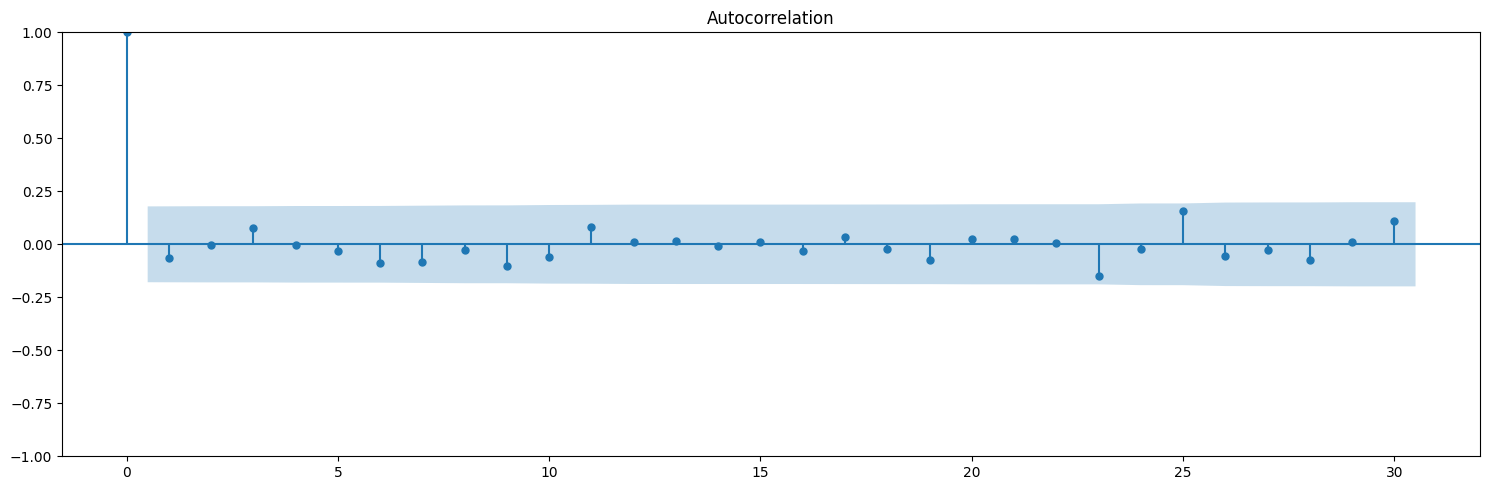

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5), facecolor = "w")
plot_acf(sarimax_grid.resid[12:], lags = int(len(sarimax_grid.resid[12:]) / 4), ax = ax)
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lag_idx = round(len(sarimax_grid.resid[12:])/4, 0)
bj = acorr_ljungbox(sarimax_grid.resid[12:], lags = lag_idx, return_df = True)
bj.tail().T

,26,27,28,29,30
lb_stat,15.494852,15.591562,16.449164,16.462164,18.403066
lb_pvalue,0.947600,0.960291,0.958691,0.969889,0.951636


# Forecast dataframe

In [ ]:
sarimax_model1 = np.exp(sarimax_model.fittedvalues[12:])
sarimax_model1

,0
2014-05,47.364235
2014-06,67.816087
2014-07,70.221927
2014-08,51.856547
2014-09,46.398892
...,...
2023-12,208.880400
2024-01,199.093203
2024-02,194.206709
2024-03,162.555279


In [ ]:
sarimax_grid1= np.exp(sarimax_grid.fittedvalues[12:])
sarimax_grid1

,0
2014-05,79.220930
2014-06,66.895256
2014-07,71.249793
2014-08,47.986703
2014-09,35.477959
...,...
2023-12,214.442239
2024-01,204.638772
2024-02,197.320100
2024-03,168.886377


In [ ]:
fitted = pd.DataFrame(
    {
        "y_train": y_train[12:],
        "SARIMAX": sarimax_model1,
        "SARIMAX Grid": sarimax_grid1
    }
)
fitted

,y_train,SARIMAX,SARIMAX Grid
2014-05,73.07,47.364235,79.220930
2014-06,70.86,67.816087,66.895256
2014-07,53.69,70.221927,71.249793
2014-08,36.80,51.856547,47.986703
2014-09,45.64,46.398892,35.477959
...,...,...,...
2023-12,208.10,208.880400,214.442239
2024-01,209.52,199.093203,204.638772
2024-02,191.17,194.206709,197.320100
2024-03,168.70,162.555279,168.886377


In [ ]:
fitted.to_excel(r"fitted train.xlsx")

In [ ]:
error_fit = pd.DataFrame()
for i in fitted.columns[1:]:
    error_fit[i] = fitted["y_train"] - fitted[i]
error_fit

,SARIMAX,SARIMAX Grid
2014-05,25.705765,-6.150930
2014-06,3.043913,3.964744
2014-07,-16.531927,-17.559793
2014-08,-15.056547,-11.186703
2014-09,-0.758892,10.162041
...,...,...
2023-12,-0.780400,-6.342239
2024-01,10.426797,4.881228
2024-02,-3.036709,-6.150100
2024-03,6.144721,-0.186377


In [ ]:
error_fit.to_excel(r"Seasonal resid.xlsx")

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
for i in list(fitted.columns):
    fig.add_trace(go.Scatter(x = fitted.index.to_timestamp(), y = fitted[i], name = i, line_shape='linear'))

fig.update_layout(title = "Line chart for compare train model",
                  xaxis_title = "Date",
                  yaxis_title = "Exchange",
                  legend_title = "Model")
fig.show()

In [ ]:
from sklearn.metrics import r2_score

diag_fitted = pd.DataFrame()
diag_fitted.index = fitted.columns[1:]
diag_fitted['MAPE'] = [MAPE(fitted['y_train'], fitted[i]) * 100 for i in fitted.columns[1:]]
# diag_fitted['RMSE'] = [sqrt(MSE(fitted['y_train'], fitted[i])) for i in fitted.columns[1:]]
# diag_fitted['MAE']  = [MAE(fitted['y_train'], fitted[i]) for i in fitted.columns[1:]]
diag_fitted['Rsquared'] = [r2_score(fitted['y_train'], fitted[i]) for i in fitted.columns[1:]]  # เพิ่มบรรทัดนี้

round(diag_fitted, 4)

,MAPE,Rsquared
SARIMAX,8.7094,0.9690
SARIMAX Grid,8.0685,0.9735


# Forecast dataframe

In [ ]:
sarimax_model2 = np.exp(sarimax_model.forecast(steps = len(y_test)))
sarimax_grid2 = np.exp(sarimax_grid.forecast(steps = len(y_test)))

In [ ]:
forecast = pd.DataFrame(
    {
        "y_test":        y_test,
        "SARIMAX":       sarimax_model2,
        "SARIMAX Grid":  sarimax_grid2
    }
)
forecast

,y_test,SARIMAX,SARIMAX Grid
2024-05,122.28,127.403193,131.718274
2024-06,123.80,132.163210,139.356412
2024-07,114.57,128.619627,138.859008
2024-08,119.58,128.893314,142.860875
2024-09,153.57,162.915364,177.893146
2024-10,204.64,184.348028,202.747477
2024-11,213.81,193.773608,216.576993
2024-12,219.47,200.502535,227.052657
2025-01,202.04,193.129745,223.578574
2025-02,181.58,174.934084,208.491016


In [ ]:
forecast.to_excel(r"forecast test.xlsx")

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
for i in list(forecast.columns):
    fig.add_trace(go.Scatter(x = forecast.index.to_timestamp(), y = forecast[i], name = i, line_shape='linear'))

fig.update_layout(title = "Line chart for compare train model",
                  xaxis_title = "Date",
                  yaxis_title = "y",
                  legend_title = "Model")
fig.show()

In [ ]:
from sklearn.metrics import r2_score

diag_forecast = pd.DataFrame()
diag_forecast.index = forecast.columns[1:]
diag_forecast['MAPE'] = [MAPE(forecast['y_test'], forecast[i]) * 100 for i in forecast.columns[1:]]
# diag_forecast['RMSE'] = [sqrt(MSE(forecast['y_test'], forecast[i])) for i in forecast.columns[1:]]
# diag_forecast['MAE']  = [MAE(forecast['y_test'], forecast[i]) for i in forecast.columns[1:]]
diag_forecast['Rsquared'] = [r2_score(forecast['y_test'], forecast[i]) for i in forecast.columns[1:]]

round(diag_forecast, 4)

,MAPE,Rsquared
SARIMAX,7.4274,0.8835
SARIMAX Grid,11.7331,0.7436
